<a name="cell-TOC-opt"></a>

### 10. [A Closer look at Newton's Method](#cell-opt-fx-)
  0. [Some Uses of Newton's Method](#cell-opt-fx-2)
    0. [Sandwich Estimator](#cell-opt-fx-sandwich)
    1. [M Estimation](#cell-opt-fx-m-est)
      - [Huber Loss](#cell-opt-fx-huber): Week 10 Programming Assignment Problem 2
    2. [Gauss-Newton](#cell-opt-fx-gauss-newton)
  1. [Altering Newton's Methods](#cell-opt-fx-3)

    0. [Newton-Like Methods](#cell-opt-fx-newtonlike)
      - [Ensuring Monotonic Iteration](#cell-opt-fx-newton-like-ascent)
    1. [Quasi-Newton Methods](#cell-opt-fx-quasi-newton)
    2. [Gradient Methods](#cell-opt-fx-common-optimization-algorithms)
      - [Hessian Diagonal Alternatives](#cell-opt-fx-common-optimization-algorithms2)
    3. [Fisher Scoring](#cell-opt-fx-fisher)
      - [Iteratively Reweighted Least Squares (IRLS)](#cell-opt-fx-irls): Week 10 Programming Assignment Problem 1
      - [Quasi-Likelihoods](#cell-opt-fx-quasi)
      - [Modified Newton Methods](#cell-opt-fx-modified-newton)
    
  2. [Not Newton's Method](#cell-opt-fx-notnewt)
    0. [Nelder-Mead](#cell-opt-fx-nelder-mead)
    1. ~Combinatorial (Discrete) Optimzation~
      - ~Simulated Annealing~
    2. ~Constrained optimization~
      - ~Expectation-Maximization~
      - ~Interior and Exterior Point Algorithms~


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.optimize import fmin_l_bfgs_b
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD, Adagrad, RMSprop

<a name="cell-opt-fx-"></a>

# 10. A Closer Look at Newton's Method ([Return to TOC](#cell-TOC-opt)) 
---

Essentially all derivative-based optimization methods can be viewed as some sort of approximation or simplification of ***Newton's method*** in order to either (a) reduce the computational cost or (b) extend the usefulness of Newton's method into the context of ***non-convex*** functions.


<a name="cell-opt-fx-2"></a>

# 10.0 Some Uses of Newton's Method ([Return to TOC](#cell-TOC-opt)) 
---

There are many situations where ***Newton's method*** isn't computationally prohibitive and the functions of interest are reasonably ***convex***.  In these cases, using ***Newton's method*** can be very effective and provides some interesting and useful results as shown by the following examples. 


<a name="cell-opt-fx-sandwich"></a>

## 10.0.0 Sandwich Estimator ([Return to TOC](#cell-TOC-opt)) 

---

*Uncertainty estimation can be facilitated by ***Newton's method***.*

The maximization of the ***log likelihood*** 

$$g(\theta) = \log f(x|\theta) = \sum_{i=1}^n \log f(x_i|\theta) = \sum_{i=1}^n g_i(\theta)$$

by ***Newton's Method*** is

\begin{align*}
\theta^{(t+1)} & = {} \theta^{(t)} - \frac{g'(\theta^{(t)})}{g''(\theta^{(t)})}\\
& = {} \theta^{(t)} -  \frac{ \sum_{i=1}^n  g_i'(\theta^{(t)})}{ \sum_{i=1}^n  g_i''(\theta^{(t)})} \\
& = {} \sum_{i=1}^n \frac{g_i''(\theta^{(t)})}{\sum_{j=1}^n g_j''(\theta^{(t)})} \left( \theta^{(t)} + \frac{g_i'(\theta^{(t)})}{g_i''(\theta^{(t)})} \right) \\
& = {} \sum_{i=1}^n w_j\left( \theta^{(t)} + \frac{g_i'(\theta^{(t)})}{g_i''(\theta^{(t)})} \right) \\
\end{align*}

which is a weighted average.

At convergence the variance of the pseudo sample $\left\{\theta^{*} + \frac{g_i'(\theta^{*})}{g_i''(\theta^{*})}: i=1,\cdots,n \right\}$$\require{cancel}$ is 

\begin{align*}
\hat \sigma^2 & = {} \sum_{i=1}^n \frac{g_i''(\theta^{*})^2}{\left(\sum_{j=1}^n g_j''(\theta^{*})\right)^2 } \left(\theta^{*} + \frac{g_i'(\theta^{*})}{g_i''(\theta^{*})}  - \cancel{\text{E}\left[\theta^{*} + \frac{g_i'(\theta^{*})}{g_i''(\theta^{*})}\right]}^{\theta^{*}}\right)^2\\
& = {}  \sum_{i=1}^n \frac{g_i''(\theta^{*})^2}{\left(\sum_{j=1}^n g_j''(\theta^{*})\right)^2 } \left(\frac{g_i'(\theta^{*})}{g_i''(\theta^{*})}\right)^2 = \frac{ \sum_{i=1}^n g_i'(\theta^{*})^2}{\left(\sum_{j=1}^n g_j''(\theta^{(t)})\right)^2 }
\end{align*}

which is the ***sandwich estimate*** of the variance of the estimate $\theta^*$. 


<a name="cell-opt-fx-m-est"></a>

## 10.0.1 M Estimation ([Return to TOC](#cell-TOC-opt)) 

---

*Use of alternative loss functions besides $L_2$ can be facilitated by ***Newton's method***.*


***M (maximum likelihood type) estimators*** consider optimizing 

$$\min_\beta \sum_{i=1}^n \rho(y_i-x_i^T \beta)$$

Where $\rho(0)=0$ and $\rho(t)$ increases as $|t|$ increases, and $\psi = \rho' \neq 0$ and $\psi' \neq 0$.

The gradient of this function is

$$\nabla_\beta \sum_{i=1}^n \rho(y_i-x_i^T \beta) = \sum_{i=1}^n \psi(y_i-x_i^T \beta)x_i = X^T\psi(y-X\beta)$$

and the Hessian is subsequently

$$\sum_{i=1}^n \psi'(y_i-x_i^T \beta)x_ix_i^T = X^TWX$$

where $W$ is a diagonal matrix with $W_{ii} = \psi'(y-X\beta)_i$.

***Newton's method*** is thus 

\begin{align*}
\beta^{(t+1)} & = {} \beta^{(t)} - (X^TWX)^{-1} X^T\psi(y-X\beta^{(t)})\\
& = {} (X^TWX)^{-1} X^TW \left[X\beta^{(t)}  -  W^{-1}\psi(y-X\beta^{(t)}) \right] \\
\end{align*}

where the last line shows that $\beta^{*}$ is found as a sequence of ***iteratively reweighted least squares*** problems. 

That is, $\beta^{(t+1)}$ is the solution to a ***weighted least squares*** problem with outcome variable is $\left[X\beta^{(t)} -  W^{-1}\psi(y-X\beta^{(t)}) \right]$, weights $W_{ii}$, and design matrix $X$.

In [3]:
# Here's an example of rho and psi

@np.vectorize
def huber_loss(t,c):
  if np.abs(t)<=c:
    return t**2/2
  return c*np.abs(t)-c**2/2

@np.vectorize
def huber_slope(t,c):
  if t>c:
    return c
  elif t<-c:
    return -c
  else:
    return t

<a name="cell-opt-fx-huber"></a>

### Huber Loss ([Return to TOC](#cell-TOC-opt)) 

---

If

$$\rho_c(t) = \left\{\begin{array}{ll}t^2/2&|t|\leq c\\ c|t| + c^2/2 & |t|>c\end{array}\right. \quad \text{ then } \quad \psi_c(t) = \left\{\begin{array}{ll}c&t>c\\t & |t| \leq c\\-c&t<-c\end{array}\right. \quad \text{ and } \quad \psi'_c(t) = \left\{\begin{array}{ll}0&t>c\\1 & |t| \leq c\\0&t<-c\end{array}\right.$$

So $W_{ii} = 0$ whenever $|y_i - x_i^T\beta|>c$ and $W_{ii} = 1$ whenever $|y_i - x_i^T\beta| \leq c$. Thus, the update 

\begin{align*}
\beta^{(t+1)} & = {} (X^TWX)^{-1} X^TW \left[X\beta^{(t)}  -  W^{-1}\psi(y-X\beta^{(t)}) \right]\\
& = {} ({X_c^TX_c})^{-1} X_c^T y_c
\end{align*}

which only includes data $X_c$ and $y_c$ which includes all $x_i$ and $y_i$ which satisfy $|\psi_c(y_i-x_i^t\beta^{(t)})| \leq c$.

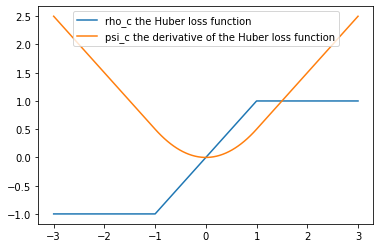

In [4]:
t = np.linspace(-3.,3.,100)
plt.plot(t, huber_slope(t,1.), label="rho_c the Huber loss function")
plt.plot(t, huber_loss(t,1.), label="psi_c the derivative of the Huber loss function")
plt.legend()

- The [Week 10 Programming Assignment Problem 2]() will implement a linear regression with ***Huber loss*** as opposed to ***least squares (squared loss)***.

<a name="cell-opt-fx-gauss-newton"></a>

## 10.0.2 Gauss-Newton ([Return to TOC](#cell-TOC-opt)) 

---

*The use of nonlinear functions is readily facilitated by ***Newton's method*** when first order approximations of functions are reasonably accurate.*

The nonlinear least squares problem

$$\min_\theta ||y-f_\theta(z)||^2_2 \not = \min_x ||b-Ax||^2_2$$

can be approximated with a linear least squares problem using a ***first-order Taylor series approximation*** for each observation

$$f_\theta(z_i) \approx f_{\theta^{(t)}}(z_i) + (\theta-\theta^{(t)})^T \nabla_\theta f_\theta^{(t)}(z_i)$$ 

yielding
$$\min_\theta \Bigg|\Bigg|\; \overbrace{\left[ \begin{array}{c}y_1\\\vdots\\y_i\\\vdots\\y_n\end{array}\right] - \left[ \begin{array}{c} f_{\theta^{(t)}}(z_1) \\\vdots\\f_{\theta^{(t)}}(z_i)\\\vdots\\f_{\theta^{(t)}}(z_n)\end{array}\right]}^{\tilde Y^{(t)}} \;\; -  \underbrace{\overbrace{\left[ \begin{array}{c} \nabla_\theta f_{\theta^{(t)}}(z_1)^T \\\vdots\\\nabla_\theta f_{\theta^{(t)}}(z_i)^T\\\vdots\\\nabla_\theta f_{\theta^{(t)}}(z_n)^T\end{array}\right]}^{\tilde X^{(t)}}}_{J_{f_{\theta}(z)}(\theta^{(t)})\,=\,\left(\nabla_{\theta}f_{\theta^{(t)}}(\,z)\right)^T}\overbrace{\left[ \begin{array}{c}\theta-\theta^{(t)}_1\\\vdots\\\theta-\theta^{(t)}_k\\\vdots\\\theta-\theta^{(t)}_p\end{array}\right]}^{\overset{\Delta\;\;\;}{\tilde \beta^{(t+1)}}} \; \Bigg|\Bigg|^2_2$$

This is known as the ***Gauss-Newton method*** and it has the least squares solution and iterative update

$$
\begin{align*}
\overset{\Delta}{\quad\;\tilde \beta^{(t+1)}} = {} & \left((\tilde X^{(t)})^T\tilde X^{(t)}\right)^{-1} (\tilde X^{(t)})^T \tilde Y^{(t)}, \text{ or}\\
\theta^{(t+1)} = {} & \theta^{(t)} + \left(J_{f_\theta(z)}(\theta^{(t)})^TJ_{f_\theta(z)}(\theta^{(t)})\right)^{-1} J_{f_\theta(z)}(\theta^{(t)})^T \tilde Y^{(t)}
\end{align*}
$$

where of course the inversion would not be computed here this will instead be solved as a system of linear equations.


> - This is exactly ***Newton's method*** for the ***least squares*** objective function when $f_\theta(z)$ is replaced with its ***first order Taylor series approximation*** since, as previously noted alongside the introduction of the ***Jacobian***, the ***Hessian*** of this objective function is the inner product of the ***Jocobian*** of $f$.
> - Both the ***Gauss-Newton method*** and ***M estimation*** solve a sequence of ***least squares*** problems, but ***Gauss-Newton*** is different ***M estimation*** since 
>   - it is not ***iteratively reweighteded*** 
>   - it is a least squares problem based on approximation whereas ***M estimation*** directly specifies a linear model form
>   - it's ***Hessian*** approximation (calculation) does not require second order derivatives 
>
> - A primary motivation of the ***Gauss-Newton method*** is the substitution of the less demanding inner product of a ***Jacobian*** in place of the potentially prohibitive calculation of the ***Hessian***.
> - The ***condition*** of $J_{f_\theta(z)}(\theta^{(t)})$ will be a driver for how effective this method can be; and, is subject to ***artificial ill-conditioning*** if the scales of $\theta_j$, and hence the elements of $\nabla_\theta {f_\theta(z_i)}$, are too different... "center and scale your data"!
> - The ***Gauss-Newton method*** will probably not converge for poorly fitting models, but it will converge quickly when the model fits well or $f$ is nearly linear.
> - When the ***Gauss-Newton*** is dampened by ***step size factor*** $\alpha$ for possible ***backtracking*** and improved ***line search***, it is known as the ***modified Gauss-Newton*** algorithm. 

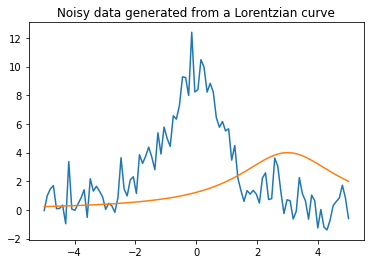

In [5]:
n = 100
x = np.linspace(-5,5,n)
y = np.array([-0.04241968,  0.99472692,  1.46136709,  1.69783109,  0.09136494,
        0.10328747,  0.33459274, -0.95961782,  3.37643212,  0.05894329,
       -0.02375809,  0.41763676,  0.83888061,  1.40835534, -0.51763923,
        2.17880416,  1.3141562 ,  1.65314959,  1.31085976,  0.91729539,
        0.04340638,  0.46099399,  0.2908898 , -0.16254184,  0.86570905,
        3.64394349,  1.47214181,  0.98306952,  2.10230834,  2.3144478 ,
        1.15205747,  3.85389004,  3.24838418,  3.74157532,  4.38135245,
        3.6991966 ,  2.8086698 ,  5.38317327,  3.89871154,  5.77992931,
        4.99042637,  4.43557394,  6.57268913,  6.33461487,  7.29644001,
        9.28410845,  9.23606016,  7.9830918 , 12.39492388,  8.23567825,
        8.38987408, 10.4842902 ,  9.95452683,  8.2193077 ,  8.82962424,
        8.22969484,  6.43676618,  5.77055729,  6.1667942 ,  5.51438084,
        5.66141588,  3.47588459,  4.49567897,  2.22952304,  1.36246895,
        0.60024175,  1.35347034,  1.10556801,  1.36483442,  1.1073268 ,
        0.47939686,  2.22805542,  2.59109509,  0.72635021,  0.78848517,
        3.61547614,  3.03755397,  1.25754956, -0.24928762,  0.71108643,
        0.64633145, -0.63206285, -0.08507482,  2.25897804,  1.12564098,
        0.62971679, -0.64366294,  1.03681281,  0.64109991, -1.25298616,
        0.03276321, -1.18998924, -1.39197099, -0.71243065,  0.30486192,
        0.58965177,  0.82886567,  1.72342942,  0.83374295, -0.60082822])
plt.plot(x,y); plt.title("Noisy data generated from a Lorentzian curve")

d = 3
@tf.function(input_signature=(tf.TensorSpec(shape=[d], dtype=tf.float64),
                              tf.TensorSpec(shape=[n], dtype=tf.float64),))
def Lorentzian(theta, x):
  return theta[0]/(((theta[1] - x)/theta[2])**2 + 1.)
# The Lorentzian curve is a nonlinear function that may model this data

a,b,c = 4.,3.,2.
plt.plot(x, Lorentzian([a,b,c], x));

In [6]:
out = np.zeros((21,21))
for i,A in enumerate(np.linspace(-20,21,21)):
  for j,B in enumerate(np.linspace(-20,21,21)):
    out[i,j] = ((Lorentzian([1,A,B], x).numpy() - y)**2).mean()
A,B = np.meshgrid(np.linspace(-20,21,21), np.linspace(-20,21,21))

# https://plotly.com/python/3d-surface-plots/
fig = make_subplots(rows=1, cols=2, specs=[[{'is_3d': True}, {'is_3d': True}]])
fig.add_trace(go.Surface(x=A, y=B, z=out), 1, 1)

#The Lorentzian is a 3 parameter function, so the MSE of the Lorentzian 
# for any value of theta for the data above is a 4D surface. 
# Below, two three-dimensional slices of the Lorentzian are visualized.
out = np.zeros((21,21))
for i,A in enumerate(np.linspace(-10,11,21)):
  for j,B in enumerate(np.linspace(-10,11,21)):
    out[i,j] = ((Lorentzian([A,0,B], x).numpy() - y)**2).mean()
A,B = np.meshgrid(np.linspace(-10,11,21), np.linspace(-10,11,21))
# https://plotly.com/python/3d-surface-plots/
fig.add_trace(go.Surface(x=A, y=B, z=out), 1, 2)

<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([ 9.98279525, -0.05594757,  0.95997712])>

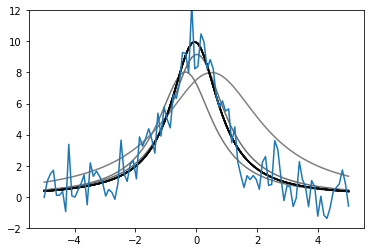

In [8]:
# Gauss-Newton algorithm which can adjust the parameters of the Lorentzian 
# to optimally fit the curve to the data provided above

T = tf.transpose
backtracking = True
theta = tf.Variable(np.array([8.0,0.5,2.0]))
#theta = tf.Variable(np.array([1.,4.,.1]))
#theta = tf.Variable(np.array([4., 3., 2.]))
#theta = tf.Variable(np.array([5.,3.,2.]))
K = 15
for k in range(K):
    plt.plot(x,Lorentzian(theta, x), color=plt.get_cmap('gray')((K-k)/(2*K)))
    with tf.GradientTape() as t:
        yhat = Lorentzian(theta, x)
    ytilde = tf.expand_dims(y-yhat,-1)
    # https://www.tensorflow.org/guide/advanced_autodiff
    Jf_theta = t.jacobian(yhat, theta)
    JtJ = T(Jf_theta)@Jf_theta
    prop = tf.Variable(tf.linalg.solve(JtJ, 
                       JtJ@tf.expand_dims(theta,-1) + T(Jf_theta)@ytilde)[:,0])

    # ensure monotonic divergence with linesearch
    if backtracking:
      for i in range(K):
        if np.abs(y-Lorentzian(prop, x)).sum()>np.abs(y-Lorentzian(theta, x)).sum():
          prop = (prop+theta)/2
        else:
          break
    theta = tf.Variable(prop)

plt.plot(x,y); plt.ylim((-2,12))
theta


<a name="cell-opt-fx-3"></a>

# 10.1 Altering Newton's Methods ([Return to TOC](#cell-TOC-opt)) 

---

***Iterative methods*** which optimize $g(x^{(t)})$ are ***fixed point iteration methods*** and take the form $x^{(t+1)} = x^{(t)} + \alpha h(x^{(t)})$ for $\alpha \neq 0$. E.g., for ***positive definite Hessian*** $H_{g(x)}$ examples include

- ***Newton's method*** $x^{(t+1)} = x^{(t)} - \alpha H_{g(x)}^{-1}(x^{(t)})\nabla_x g(x^{(t)})$ with ***learning rate*** $\alpha$
  > which (as seen previously) converges if $||\alpha H_{g(x)}^{-1}(x^{(t)})H_{g(x)}(x^*)||=\lambda_\max < 1$ which is true for constant $H_{g(x)}$ and $\alpha=1$ since then $\left|\left| I - \alpha H_{g(x)}^{-1}(x^{(t)}) H_{g(x)}(x^*) \right|\right| = ||I-I||=0<1$

- ***Gradient Descent*** $x^{(t+1)} = x^{(t)} - \alpha I \nabla_x g(x^{(t)})$
  > which (following from the above) converges if $||\alpha H_{g(x)}(x^*)||=\lambda_\max < 1$; and, the smaller $\left|\left| I - \alpha H_{g(x)}(x^*) \right|\right| < 1$ the faster the convergence will be

- or most generally $x^{(t+1)} = x^{(t)} - \alpha [M^{(t)}]^{-1}\nabla_x g(x^{(t)})$ 
  > which converges if $||\alpha [M^{(t)}]^{-1}H_{g(x)}(x^*)||=\lambda_\max < 1$; and, the smaller $\left|\left| I - \alpha [M^{(t)}]^{-1}H_{g(x)}(x^*) \right|\right| < 1$ the faster the convergence will be


<a name="cell-opt-fx-newtonlike"></a>

## 10.1.0 Newton-Like Methods ([Return to TOC](#cell-TOC-opt)) 

---

***Newton-like methods*** use simpler alternatives $M^{(t)}$ in place of the Hessian $H_{g(z)}(z^{(t)})$ in order to substitute

$$x^{(t+1)} = x^{(t)} - \alpha[M^{(t)}]^{-1}\nabla_x g(x^{(t)}) \quad \text{ for } \quad x^{(t+1)} = x^{(t)} - \alpha\left[H_{g(x)}(x^{(t)})\right]^{-1}\nabla_x g(x^{(t)})$$

While the approximation $M^{(t)} \approx H_{g(x)}(x^{(t)})$ may attempt to be accurate, it may be more computationally efficient to instead use a simple $M^{(t)}$ that's easy to compute and then simply perform more overall updates $x^{(t+1)} = x^{(t)} + g(x^{(t)})$. This is the motivation behind the seemingly misguided $\alpha I \approx \alpha H_{g(x)}(z^{(t)})$ strategy. 

> To avoid computing the $O(n^3)$ inversion $[M^{(t)}]^{-1}$ when solving for the update direction $d = \nabla_x [M^{(t)}]^{-1} f(x)$, the direction $d$ should be found by solving for $d$ in $M^{(t)}d = \nabla_x f(x)$. The ***Gauss-Seidel*** and ***conjugate gradient descent*** $O(sn^2)$ ***iterative methods*** can be particularly computationally beneficial for high dimensional $d$. Such an approach is known as a ***Truncated Newton methods***, where "truncated" refers to the number of steps $s$ used to approximate the solution $d$. ***Truncated Newton methods*** can be ***Newton-like methods*** in their  "outer loop", but they also have an "inner loop" of $s$ steps in which they approximate the update direction $d$. 

<a name="cell-opt-fx-newton-like-ascent"></a>

### Ensuring Monotonic Iteration ([Return to TOC](#cell-TOC-opt)) 

---

***Newton-like updates*** $x^{(t+1)} = x^{(t)} - \alpha M^{-1}\nabla_x g(x^{(t)})$ move towards $x^*$ such that $\nabla_x g(x^*) = 0$, but only in a  monotonically decreasing (increasing) manner if $M$ is ***positive*** (***negative***) ***definite*** and some sufficiently small ***learning rate*** $\alpha \neq 0$.

Since 
- $M+cI$ will (have all positive ***eigenvalues*** and) be positive definite if $c>0$ is large enough   
- $M+cI$ will (have all negative ***eigenvalues*** and) be negative definite if $c<0$ is small enough 

  > and these forms of definiteness could also be achieved with diagonal $D_c$ with $[D_c]_{ii} = c_i$ which minimizes alteration of the original $M$ through the so-called [***modified Cholesky decomposition***](https://nhigham.com/2020/12/22/what-is-a-modified-cholesky-factorization/)

***modified Newton methods*** guarantee monotonic convergence by instead updating

$$x^{(t+1)} = x^{(t)} - \alpha \underset{\text{or } M+D_c}{(M+cI)}^{-1}\nabla_x g(x^{(t)})$$

This guarantees monotonic $g(x^{(t+1)})<g(x^{(t)})$ since $(M+cI)^{-1}\nabla_x g(x^{(t)})$ will have the same signs as $\nabla_x g(x^{(t)})$ and so 
$$g\left(x^{(t)} - \alpha {(M+cI)}^{-1}\nabla_x g(x^{(t)})\right)$$

must be less than $g(x^{(t)})$ for some small $\alpha>0$.

> Since ***gradient descent*** follows the direction of steepest descent of $g$ at $x^{(t)}$ (by moving in the negative direction of the gradient) for some small step size factor $\alpha^{(t)} > 0$, since $I$ is positive definite, we will have that $g(x^{(t+1)}) < g(x^{(t)})$.

After ensuring the necessary ***positive (negative)definiteness***, the ***step size factor*** $\alpha$ can be found by the ***line search method*** of ***backtracking***. If monotonic convergence is violated for a specific $\alpha^{(t)}$ then is can be made smaller.

<a name="cell-opt-fx-quasi-newton"></a>

## 10.1.1 Quasi-Newton Methods ([Return to TOC](#cell-TOC-opt)) 

---

As noted previously, the naive generalization of the ***secant method*** to scalar valued multivariate functions as a discrete approximation to ***Newton's method*** does not offer any computational incentives over simply computing the Hessian itself.  However, for 

- sequential iterations $\quad x^{(t)}$ and $x^{(t-1)}$
- sequential gradients  $\quad \nabla_{x}g(x^{(t)})$ and $\nabla_{x}g(x^{(t-1)})$

an $M^{(t)}$ satisfying the so-called ***secant condition***

$$ \underbrace{\nabla_{x}g(x^{(t)}) - \nabla_{x}g(x^{(t-1)})}_{\Delta^{(t)}_{\nabla_{x}g}} = M^{(t)}\underbrace{(x^{(t)} - x^{(t-1)})}_{\Delta_x^{(t)}}$$

provides the discrete ***secant*** approximation of the Hessian where

$$x^{(t+1)} = x^{(t)} - \left[M^{(t)}\right]^{-1}\nabla_x g(x^{(t)}) \quad \text{ replaces } \quad x^{(t+1)} = x^{(t)} - \left[H_{g(x)}(x^{(t)})\right]^{-1}\nabla_x g(x^{(t)})$$

and where $M^{(t)}$ which satisfies the ***secand condition*** can be derived iteratively on the basis of $M^{(t-1)}$ which itself already satisfies the ***secand condition***. This is shown in the following material, but understanding that there are available calculations here is more important than understanding the specific computations themsevles.

> This ***secant condition*** alone does not provide an efficient calculation of $M^{(t)}$, but the (computationally inexpensive) ***rank-one update*** [derived here](https://personal.math.ubc.ca/~loew/m604/web-ho/sr1.pdf)
>
> $$M^{(t)} = M^{(t-1)} + \underbrace{\frac{v^{(t)}[v^{(t)}]^T}{[v^{(t)}]^T\Delta_x^{(t)}c}}_{\text{rank-one update}} \quad \text{ where } \quad v^{(t)} = \left(\Delta^{(t)}_{\nabla_{x}g} - M^{(t-1)}\Delta_x^{(t)}\right)$$
>
> results in $M^{(t)}$ which satisfies the ***secant condition***, subject to the following caveats.
> - If the denomenator $[v^{(t)}]^T\Delta_x^{(t)} \approx 0$, the update might need to be skipped by setting $M^{(t+1)} = M^{(t)}$.
> - If the denomenator $[v^{(t)}]^T\Delta_x^{(t)}<0$ $(>0)$ and $M^{(t-1)}$ is ***negative*** $($***positive***$)$ ***definite***, then $M^{(t)}$ will be as well.
>   - Thus, this update only guarantees ***hereditary positive $($negative$)$ definiteness*** under the above conditions; however,
>   - scaling $[v^{(t)}]^T\Delta_x^{(t)}$ in the denominator by some large factor $c$ so the update contributes less to $M^{(t)}$ can maintain the definiteness state.

> A ***rank-two version*** of the above which both satisfies the ***secant condition*** and confers ***hereditary definiteness*** is the so-called ***BFGS*** update (named after its authors). The (*rank-two*) ***BFGS*** update is just the (*rank-two*) ***Broyden class update*** 
> 
> $$\begin{align*} M^{(t)} = {} & M^{(t-1)} - \frac{M^{(t-1)}\Delta_x^{(t)} [M^{(t-1)}\Delta_x^{(t)}]^T}{[\Delta_x^{(t)}]^TM^{(t-1)}\Delta_x^{(t)}} + \frac{\Delta^{(t)}_{\nabla_{x}g}[\Delta^{(t)}_{\nabla_{x}g}]^T}{[\Delta_x^{(t)}]^T\Delta^{(t)}_{\nabla_{x}g}} + \delta^{(t)}\left([\Delta_x^{(t)}]^TM^{(t-1)}\Delta_x^{(t)} \right)[d^{(t)}]^Td^{(t)}\\
{} & \text{where } d^{(t)} = \frac{\Delta^{(t)}_{\nabla_{x}g}}{[\Delta_x^{(t)}]^T\Delta^{(t)}_{\nabla_{x}g}} - \frac{M^{(t-1)}\Delta_x^{(t)}}{[\Delta_x^{(t)}]^TM^{(t-1)}\Delta_x^{(t)}}
\end{align*}$$
>
> with $\delta^{(t)}=0$. 

> A few points to note regarding ***quasi-Newton methods*** are:
> - many authors find the ***rank-one update*** to have superior performance to ***Broyden class updates***, including ***BFGS***
- the above ***BFGS*** update is numerically unstable, and is better approached through a ***Cholesky decomposition*** 
>   - ***quasi-Newton methods*** are very sensitive to the scale of the $x_i$ comprising $x$, with performance tending to be better for similarly scaled $x_i$
>   - ***quasi-Newton methods*** are very sensitive to the initial choice $M^{(0)}$ though for similarly scaled $x_i$ starting with $I$ (for minimization) or $-I$ (for maximization) is usually sufficient; however, in maximum likelihood estimation contexts starting with $-I(\theta^{(0)})$ is usually a better choice
- the ***observed information*** (i.e., the negative Hessian) provides a point estimate of the ***precision*** (i.e., inverse covariance) structure of $p(\hat \theta) \approx N(\theta, \Sigma^{-1} = -H_{l(\theta)}(\hat \theta))$, but quasi-Newton methods  (intentionally) do not provide close estimates of the Hessian; so, for statistical purposes, re-estimating the ***observed information*** upon convergence is an obligatory final step, e.g., with the ***central difference approximation***
>
>   $$ \widehat{[H_{l(\theta)}(\theta^{(t)})]}_{ij} = \frac{[\nabla_\theta l(\theta^{(t)} + h_{ij}e_j)]_i - [\nabla_\theta l(\theta^{(t)} - h_{ij}e_j)]_i}{2h_{ij}} $$
>   perhaps with $h_{ij} = h = \epsilon^{\frac{1}{3}}$ where $\epsilon$ is the available computer precision. 

In [11]:
np.random.seed(3)
alpha,K = 0.01,10
d,q1,q2 = 3,2,3
# these are the data
x = np.random.normal(size=(d,1))
y = np.random.normal(size=(d,1))
# these are all the parameters
A1 = np.random.normal(size=(q1,d))
b1 = np.random.normal(size=(q1,1))
A2 = np.random.normal(size=(q2,q1))
b2 = np.random.normal(size=(q2,1))

# the parameters are passed into the function as a vector
# https://stackoverflow.com/questions/8672005/correct-usage-of-fmin-l-bfgs-b-for-fitting-model-parameters
def objective(parameters):
    # parameters get unpacked into their model form
    A1 = parameters[0:(q1*d)].reshape(q1,d)
    b1 = parameters[(q1*d):(q1*d+q1)].reshape(q1,1)
    A2 = parameters[(q1*d+q1):(q1*d+q1+q2*q1)].reshape(q2,q1)
    b2 = parameters[(q1*d+q1+q2*q1):].reshape(q2,1)
    # this is the model form
    x1 = A1@x+b1
    x1 = x1*(x1>0)
    x2 = A2@x1+b2
    # here's the residual from the prediction of this model
    epsilon = y-x2
    # and here's the loss function
    return epsilon.T.dot(epsilon)[0,0]**0.5

# https://stackoverflow.com/questions/8672005/correct-usage-of-fmin-l-bfgs-b-for-fitting-model-parameters
fmin_l_bfgs_b(func=objective, x0=np.ones(q1*d+q1+q2*q1+q2), approx_grad=True, m=4)
# showing this for a latent dimension of 4 (1 or 2 does not work)

(array([-0.96574897,  0.52026429,  0.89394679, -0.96574897,  0.52026429,
         0.89394679, -0.09902591, -0.09902591, -0.28444771, -0.28444771,
         0.11431961,  0.11431961,  0.09486785,  0.09486785, -1.86349271,
        -0.2773882 , -0.35475898]),
 4.948635670380259e-09,
 {'grad': array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.04907721,
         0.72439173, 0.68331158]),
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'funcalls': 972,
  'nit': 24,
  'warnflag': 0})

In [12]:
# Indeed this converges for BFGS with rank 4
fit_parameters = fmin_l_bfgs_b(func=objective, x0=np.ones(q1*d+q1+q2*q1+q2), approx_grad=True, m=4)[0]
A1 = fit_parameters[0:(q1*d)].reshape(q1,d)
b1 = fit_parameters[(q1*d):(q1*d+q1)].reshape(q1,1)
A2 = fit_parameters[(q1*d+q1):(q1*d+q1+q2*q1)].reshape(q2,q1)
b2 = fit_parameters[(q1*d+q1+q2*q1):].reshape(q2,1)
x1 = A1@x+b1
x1 = x1*(x1>0)
x2 = A2@x1+b2
np.c_[y,x2]

array([[-1.8634927 , -1.86349271],
       [-0.2773882 , -0.2773882 ],
       [-0.35475898, -0.35475898]])

<a name="cell-opt-fx-common-optimization-algorithms"></a>

## 10.1.2 Gradient Methods ([Return to TOC](#cell-TOC-opt)) 

---

***Gradient methods*** dispense with approximating the ***Hessian*** and ignoring it entirely, replacing $H_{g(\theta)}$ with the identity matrix $I$.  They then focus on improving the computation and performance of the ***gradient*** $\nabla_\theta g(\theta)$. This makes a lot of sense in the context of ***non-convex*** functions where the ***Hessian*** $H_{g(\theta)}$ cannot reliably support convergence towards a global optimum. And, since many modern optimization contexts involve ***non-convex*** functions, ***gradient methods*** have become ubiquitous features of the modern optimization toolkit. 

> Even for ***convex*** $g(\theta)$ the compelling argument for ***gradient methods*** over ***Newton's method*** is that they may be more computationally efficient overall.  If the computation of the ***Hessian*** is expensive relative to the computations of the ***gradient*** (as is generally the case), then skipping the ***Hessian*** computation means more update steps based on cheaper ***gradient*** computations can be made, and this may end up being more computationally efficient overall. 

The following ***gradient methods*** are frequently encountered in modern optimization contexts.

- ***Stochastic Gradient Descent*** $x^{(t+1)} = x^{(t)} - \alpha I \widehat{\nabla_x g(x^{(t)})}$
  - replaces the Hessian $H_{g(\theta)}$ with the identity matrix $I$
  - uses a step size factor $\alpha_t$ which may evolve according to a prescribed schedule
  - and makes steps using gradients estimated from small ***batches*** (e.g., $m=32$ observations) rather than all of the available data

    $$\frac{1}{m} \sum_{i=1}^m \nabla_\theta g_{x_i}(\theta_{t-1}) = \nabla_\theta \frac{1}{m} \sum_{i=1}^m g_{x_i}(\theta_{t-1}) \quad \text{ estimates } \quad E_x\left[ \nabla_\theta g_x(\theta_{t-1}) \right]$$
<!-- = \nabla_\theta g(\theta_{t-1}) -->

  Sequences of ***batches*** constructed from the full data comprise one ***epoch***, and a sequence of ***stochastic gradient descent*** steps are often constructed from multiple ***epochs***, i.e., many passes through many batches of data.

  > ***Stochastic gradient descent*** drastically reduces computation because roughly accurate estimates of the gradients can be easily computed without having to use all the data.
  >
  > More than that, however, estimating gradients from batches is empirically observed to outperform calculating gradients based on the full data set. 
  > - ***Stochastic gradient descent*** introduces noise into the iterative trajectory which increases the exploration potential of the $\theta_t$ sequence, making it less likely to coverge (***overfit***) on a suboptimal local minima; and, even within an attractive region of a local minima the $\theta_t$ sequence is ***regularized*** in the sense that it will never actually achieve the local minima value since the estimated gradient will be different for each ***batch*** of data. 

  

- ***Momentum*** replaces the gradient with a running average using prescribed ***learning rate*** $\alpha_t$ and ***historic decay*** weighting schedules $\epsilon_t$ as

  $$\begin{align*}
  v_t = {} & \epsilon_t v_{t-1} + \alpha_t \nabla_\theta \frac{1}{m} \sum_{i=1}^m g_{x_i}(\theta_{t-1})\\
  \theta_t = {} & \theta_{t-1} - v_t
  \end{align*}$$

  - ***Neterov Momentum*** is a slight variant based on the "look ahead" update $$\begin{align*}
  v_t = {} & \epsilon_t v_{t-1} + \alpha_t \nabla_\theta \frac{1}{m} \sum_{i=1}^m g_{x_i}(\theta_{t-1} + \epsilon_{t} v_{t-1})
  \end{align*}$$

    though this typically has equivalent performance to the original ***momentum*** specification.

  The idea of ***momentum*** is to use the ***gradient*** history information instead of the ***Hessian*** at each update step to predict the shape of the function being optimized.  The assumption underlying ***momentum*** is that previous ***gradients*** are good estimates of future ***gradients***. 

> ***Momentum*** takes the form
>
> $$v_t = \sum_{j=1}^{t} \underbrace{\left[\prod_{k=j}^{t-1} \epsilon_{k+1} \right]}_{1 \text{ if } k=t\;>\;t-1} \alpha_j \underbrace{\nabla_\theta \frac{1}{m} \sum_{i=1}^m g_{x_i}(\theta_{j-1})}_{\widehat{\nabla_\theta g(\theta_{j-1})}}$$
>
> for which there exists some vector $d_t$ that accounts for the difference between $v_t$ and $\epsilon_t v_{t-1}$ such that
>
> $$ v_t = \alpha_t \underbrace{d_t \odot \overbrace{\nabla_\theta \frac{1}{m} \sum_{i=1}^m g_{x_i}(\theta_{t-1})}^{\widehat{\nabla_\theta g(\theta_{t-1})}}}_{\text{element-wise multiplication}}$$
>
> The ***momentum*** update 
> 
> $$\theta_t = \theta_{t-1} - \alpha_t d_t \odot \widehat{\nabla_\theta g(\theta_{t-1})} = \underbrace{\theta_{t-1} - \alpha_t D_t^{-1} \widehat{\nabla_\theta g(\theta_{t-1})}}_{\text{expressed as diagonal matrix } D_t^{-1}}$$ 
>
> can thus be viewed as a diagonal alternative to ***Newton's method*** where the $D_t$ replaces the diagonal elements of the ***Hessian*** $H_{g(\theta)}$ with values based on the decay weighted history of ***gradients*** which force a trajectory that is a decay weighted average of the ***gradient*** history.

<a name="cell-opt-fx-common-optimization-algorithms2"></a>

### Hessian Diagonal Alternatives ([Return to TOC](#cell-TOC-opt)) 

---

***Diagonal approximations*** $H_{g(\theta)} \approx I \circ H_{g(\theta)} = D_\gamma$ which ignore the off-diagonal elements of the Hessian attempt to approximate the second order partial derivatives as 

$$[D_{\gamma}]_{ii} = \frac{\partial^2 g (\theta)}{\partial\theta_i\partial\theta_i} \approx \gamma_i \quad \text{ and } \quad [D_{\gamma}]_{ij} = \frac{\partial^2 g( \theta)}{\partial\theta_i\partial\theta_j} \approx 0$$ 

and approximate ***Newton's method*** as 

$$ \theta^{(t+1)} = \theta^{(t)} - D_\gamma^{-1} \nabla_\theta g(\theta^{(t)}) $$

As the example of ***momentum*** above shows, other alternatives for the diagonal of the ***Hessian*** are possible.

- ***Adagrad*** enables coordinate-specific learning rates by weighting the elements of a gradient step inversely to the magnitude of the step sizes accumulated along the axis so far as

  $$\begin{align*}
  g_t = {} & \nabla_\theta \frac{1}{m} \sum_{i=1}^m g_{x_i}(\theta_{t-1})\\
  r_t = {} & r_{t-1} + g_t \odot g_t \quad \text{  element-wise product}\\
  \theta_t = {} & \theta_{t-1} - \frac{\alpha_t}{\delta_t+\sqrt{r_t}} \odot g_t \quad \text{  element-wise square root, division, and product}
  \end{align*}$$

  where the square root transforms the sum back to original units, and $\delta_t>0$ ensures division by $0$ is avoided. 
  
  > The effect of the method is to make step sizes smaller along fast-moving axes and larger along slow-moving axes.


- **RMSprop** replaces the accumulation in ***Adagrad*** with a decaying running average

  $$\begin{align*}
  r_t = {} & \rho r_{t-1} + (1-\rho) g_t \odot g_t
  \end{align*}$$

  which allows for the application of locally variying coordinate-specific learning rates.

  ***RMSprop*** also admits the subsequent incorporation of ***Momentum*** as $$\begin{align*}
  v_t = {} & \epsilon_t v_{t-1} + \frac{\alpha_t}{\delta_t+\sqrt{r_t}} \odot g_t\\
  \theta_t = {} & \theta_{t-1} - v_t
  \end{align*}$$

  > ***RMSprop*** provides both the coordinate-specific learning rates of  ***Adagrad*** as well as incorporating a ***momentum*** effect.

- **Adam** is a slight variant of ***RMSprop*** which directly incorporates ***momentum*** as another decaying running average

  $$\begin{align*}
  g_t = {} & \nabla_\theta \frac{1}{m} \sum_{i=1}^m g_{x_i}(\theta_{t-1})\\
  v_t = {} & \rho_v v_{t-1} + (1-\rho_v) g_t \quad\quad \times \frac{1}{1-\rho_v^t} \text{ to correct if } v_0 = 0  \\
  r_t = {} & \rho_s r_{t-1} + (1-\rho_s) g_t \odot g_t \quad \quad \times  \frac{1}{1-\rho_s^t} \text{ to correct if } r_0=0 \\
  \theta_t = {} & \theta_{t-1} - \frac{\alpha_t}{\delta_t+\sqrt{r_t}} \odot v_t
  \end{align*}$$

  > The performance of ***Adam*** is often equivalent to that of ***RMSprop*** with ***momentum***. 

> Emtiyaz Khan characterizes these common algorithms as varying degrees of approximation to "Bayesian Learning Rules" in this [presentation](https://slideslive.com/38923183/deep-learning-with-bayesian-principles), starting around slide 60.

In [ ]:
# These popular iterative optimization techniques are readily
# available in modern computational frameworks like tensorflow

np.random.seed(3)
alpha,K = 0.01,10
d,q1,q2 = 3,2,3
x = tf.constant(np.random.normal(size=(d,1)))
y = tf.constant(np.random.normal(size=(d,1)))
A1 = tf.Variable(np.random.normal(size=(q1,d)))
b1 = tf.Variable(np.random.normal(size=(q1,1)))
A2 = tf.Variable(np.random.normal(size=(q2,q1)))
b2 = tf.Variable(np.random.normal(size=(q2,1)))

@tf.function()
def objective():
    x1 = A1@x+b1
    x1 = x1*tf.cast(x1>0, tf.float64)
    x2 = A2@x1+b2
    epsilon = y-x2   
    return tf.tensordot(tf.transpose(epsilon), epsilon, axes=1)**(0.5)

# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules
alpha_t, epsilon_t = 0.1,0.5
sgd = SGD(learning_rate=alpha_t, momentum=epsilon_t, nesterov=True)
adagrad = Adagrad(learning_rate=alpha_t)
rho_t = 0.5
rmsprop = RMSprop(learning_rate=alpha_t, rho=rho_t, momentum=epsilon_t)
rho_v_t, rho_s_t = epsilon_t, rho_t
adam = Adam(learning_rate=alpha_t, beta_1=rho_v_t, beta_2=rho_s_t)

steps = 10
for t in range(steps):
  sgd.minimize(objective, var_list=[A1, b1, A2, b2])
  #adagrad.minimize(objective, var_list=[A1, b1, A2, b2])
  #rmsprop.minimize(objective, var_list=[A1, b1, A2, b2])
  #adam.minimize(objective, var_list=[A1, b1, A2, b2])
print(objective())

x1 = A1@x+b1
x1 = x1*tf.cast(x1>0, tf.float64)
x2 = A2@x1+b2
x2,y

tf.Tensor([[1.18176167]], shape=(1, 1), dtype=float64)


(<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
 array([[-1.52092405],
        [ 0.37256329],
        [ 0.57085996]])>, <tf.Tensor: shape=(3, 1), dtype=float64, numpy=
 array([[-1.8634927 ],
        [-0.2773882 ],
        [-0.35475898]])>)

<a name="cell-opt-fx-fisher"></a>

## 10.1.3 Fisher Scoring ([Return to TOC](#cell-TOC-opt)) 

---

For the MLE context where $g(x) \equiv l(\theta)$ the [Fisher information](https://math.stackexchange.com/questions/3585130/why-is-the-fisher-information-matrix-both-an-expected-outer-product-and-a-hessia)

$$I(\theta) = {E[\nabla_\theta l(\theta)\nabla_\theta l(\theta)^T]} = E[ {{-\underbrace{H_{l(\theta)}(\theta)}_{J(\nabla_\theta l(\theta))(\theta)}}}]$$

suggest a slight variation on ***Newton's method*** known as ***Fisher scoring***

$$\begin{align*}
\theta^{(t+1)}  & {} = \theta^{(t)} - \left[H_{l(\theta)}(\theta^{(t)})\right]^{-1}\nabla_\theta l(\theta^{(t)}) \\
& {} = \theta^{(t)} + {I(\theta^{(t)})}{}^{-1}\nabla_\theta l(\theta^{(t)}) \\
& {} \approx \theta^{(t)} + \hat{I(\theta^{(t)})}{}^{-1}\nabla_\theta l(\theta^{(t)}) \\
& {} = \theta^{(t)} + \left[\sum_{i=1}^n \nabla_\theta log f(x_i|\theta)\big|_{\hat \theta}\left(\nabla_\theta log f(x_i| \theta)\big|_{\hat \theta}\right)^T \right]^{-1} \left[\sum_{i=1}^n \nabla_\theta log f(x_i|\theta)\big|_{\hat \theta}\right]\\
& {} \approx \theta^{(t)} - H_{l(\theta)}(\hat \theta)^{-1}\nabla_\theta l(\theta^{(t)}) \\
& {} = \theta^{(t)} - J(\nabla_\theta l)(\hat \theta)^{-1}\nabla_\theta l(\theta^{(t)}) \\
& {} = \theta^{(t)} - \left[\sum_{i=1}^n J( \nabla_\theta log f(x_i|\theta))\big|_{\hat \theta} \right]^{-1} \left[\sum_{i=1}^n \nabla_\theta log f(x_i|\theta)\big|_{\hat \theta}\right]
\end{align*}$$


***Fisher scoring*** which approximates the ***expected*** information (i.e., the negative Hessian) with the ***observed*** information

$$\begin{align*}
  M = -I(\theta^{(t)}) = {} & -E[\nabla_\theta l(\theta^{(t)})\nabla_\theta l(\theta^{(t)})^T] = E[H_{l(\theta)}l(\theta^{(t)})]\\
  \approx {} & -\sum_{i=1}^n \nabla_\theta log f_{x_i}(\theta^{(t)})\left(\nabla_\theta log f_{x_i}(\theta^{(t)})\right)^T \approx  H_{l(\theta)}l(\theta^{(t)}) 
  \end{align*}$$



> ***Fisher information*** $I(\theta^{(t)})$ is [***positive semi-definite***](https://stats.stackexchange.com/questions/49942/why-is-the-fisher-information-matrix-positive-semidefinite), so for some small step size factor $\alpha^{(t)}>0$
   > - the update $\theta^{(t+1)} = \theta^{(t)} + \underbrace{\alpha^{(t)}[I(\theta^{(t)})]^{-1}\nabla_\theta l(\theta^{(t)})}_{\text{will have the same sign as }\nabla_\theta g(\theta^{(t)})}$ 
   > - guarantees that $f(x^{(t+1)}) > f(x^{(t)})$
   >
   > and at a (local) maximum $\theta^*$ where $\nabla_\theta l(\theta^*)=0$, both $H_{l(\theta)}(\theta^*)$ and $E[H_{l(\theta)}(\theta^*)] = -I(\theta^*)$ will be ***negative semi-definite***.


<a name="cell-opt-fx-irls"></a>

### Iteratively Reweighted Least Squares (IRLS) ([Return to TOC](#cell-TOC-opt)) 

---

<!-- https://stats.stackexchange.com/questions/344309/why-using-newtons-method-for-logistic-regression-optimization-is-called-iterati -->

In ***exponential family*** form, the ***log likelihood*** of the ***logistic regression*** (***generalized linear model***) is

$$l(\beta) = \overbrace{y^t Z\beta - \mathbf{1}^T \underbrace{\log \left(1 + \exp(Z\beta) \right)}_{g(Z\beta)}}^{\log f(y|\theta) \;= \;[y\theta - b(\theta)]/a(\phi)+c(y,\phi)}$$

> where 
> - $\Pr(y_i=1) = \underset{\text{a property of the exponential family}}{E[y_i] = \frac{d}{d\theta_i} \overbrace{\log \left(1 + \exp(\theta_i) \right)}^{g(\theta_i)\;=\;g(z_i^T\beta)}} = \frac{\exp(\theta_i)}{1 + \exp(\theta_i)} = \frac{1}{1 + \exp(-\theta_i)}$
> - the ***natural parameter*** $\theta_i =  z_i^T\beta = \log\left(\frac{\Pr(y_i=1)}{1-\Pr(y_i=1)} \right)$ is the ***log odds***
>
>  - $\log\left(\frac{\Pr(y_i=1)}{1-\Pr(y_i=1)} \right) = \log \left( \frac{\frac{\exp(\theta_i)}{1 + \exp(\theta_i)}}{\frac{1}{1 + \exp(\theta_i)}} \right) = \log(\exp(\theta_i)) = \theta_i$
>
> - and the ***gradient*** and ***Information*** and ***Hessian*** are 
>
>  $$
  \begin{align*}
  \nabla_\beta l(\beta)  & = {}Z^Ty - Z^T\frac{\exp(Z\beta)}{1+\exp(Z\beta)} = Z^Ty - Z^T\frac{1}{1+\exp(-Z\beta)} = Z^T(y-E[y]) \\
  & = {} Z^Ty - Z^T(1+\exp(-Z\beta))^{-1} \\
  I(\beta) & = {} E\left[ Z^T (Y-E[Y])(Y-E[Y])^T Z\right] 
   = Z^T Cov\left(Y\right)Z{} = Z^T\overbrace{\text{diag}(E[Y_i](1-E[Y_i]))}^{\text{diag}(p_i(1-p_i)) \text{ for i.i.d. Bernoulli}}Z \\
  & = - E[H_{l(\beta)}(\beta)] = -H_{l(\beta)}(\beta)  \\\\
  H_{l(\beta)}(\beta) & = {} -Z^TWZ \quad \text{ where } \quad W_{ij}=0 \text{ for } i\not=j \\
  & \quad\quad\quad\quad\quad\quad\quad\, \text{ and } \quad W_{ii} = \frac{\exp(-z_i\beta)}{\left(1+\exp(-z_i\beta)\right)^2} = \frac{1}{1+\exp(-z_i\beta)}\frac{\exp(-z_i\beta)}{1+\exp(-z_i\beta)} \\
  &  \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\, = E[y_i](1-E[y_i])
  \end{align*}$$

Thus, ***Newton's method*** is 
$$\beta^{(t+1)} = \beta^{(t)} - \underbrace{\overbrace{( -Z^T \overset{(t)}{W}Z )^{-1}}^{H_{l(\beta)}(\beta^{(t)})^{-1}} \overbrace{Z^T(y-\overset{(t)}{E[y]})}^{\nabla_\beta l(\beta^{(t)})}}_{\text{$E[y]$ (and hence $W$) depends on $\beta^{(t)}$}}$$
which is identical to ***Fisher scoring***
$$\beta^{(t+1)} = \beta^{(t)} + \underbrace{\!{I(\beta^{(t)})\!}}_{-H_{l(\beta)}(\beta^{(t)})}\!\!{}^{-1} Z^T(y-\overset{(t)}{E[y]})$$

And by reorganizing the terms

> $$\begin{align*}
\beta^{(t+1)} = {} & \beta^{(t)} + I(\beta)^{-1} Z^T(y-\overset{(t)}{E[y]})\\
 = {} & I(\beta)^{-1} \left( I(\beta) \beta^{(t)} + Z^T\underbrace{\overset{(t)}{W}\overset{(t)}{W}{}^{-1}}(y-\overset{(t)}{E[y]})\right)\\
 = {} & I(\beta)^{-1} \left( \underbrace{Z^T \overset{(t)}{W}Z}_{I(\beta)} \beta^{(t)} + Z^T\overset{(t)}{W} \underbrace{(\tilde y^{(t)}-Z\beta^{(t)})}_{\dagger}\right)\\
 & \quad\quad\;\; \dagger \longrightarrow \tilde y^{(t)} = Z\beta^{(t)}+ \overset{(t)}{W}{}^{-1}(y- \overset{(t)}{E[y]}) \\
 = {} & \underbrace{\left(Z^T \overset{(t)}{W}Z\right)^{-1} \!\! Z^T\overset{(t)}{W} \tilde y^{(t)}}_{\text{which is weighted least squares}}
\end{align*}$$

these updates can be recognized as specifying a ***weighted least squares*** problem. Thus, the ***iteratively reweighted least squares*** method fits a ***logistic regression*** by 

0. initializing $\beta^{(0)}$ which implies $W^{(0)}$ and $E[y]^{(0)}$

   and then repeatedly iteratively updating between

1. updating $y^{(t)}$ with $\dagger$ based on $W^{(t)}$ and $E[y]^{(t)}$

2. $\beta^{(t+1)}$ with the solution to a ***weighted least squares*** problem.

- The implementation of an IRLS method will be addressed in [Programming Portfolio Assignment 5 Problem 2](#cell-opt).

<!--
Indeed, the function being optimized by ***IRLS*** is the ***least squares*** problem for a ***linear approximiation*** of ***linear regression*** for a ***nonlinear model*** of ***logistic regression***. It thus turns out that the ***Newton's method*** which is equivalent ***Fisher scoring*** for this problem, are both as well equivalent to the ***Gauss-Newton*** solution to this problem.  -->



<a name="cell-opt-fx-quasi"></a>

### Quasi-Likelihood ([Return to TOC](#cell-TOC-opt)) 

---

***Generalized linear models*** such as ***logistic regression*** ***poisson regression*** embed their parameters

\begin{align*}
\text{E}[y_i|x_i] & ={} \mu_i = \phi^{-1}(\theta_i = x_i^T \beta)\\
\text{Var}[y_i|x_i] & ={} V(\mu_i)
\end{align*}

within a specific ***log likelihood*** form. However, if the ***log likelihood*** does not have an explicit form, the parameters $\beta$ can still be estimated through an implicitly defined ***quasi-likehood*** $q(x|\mu)$ via the differential equation

$$\frac{d}{d\mu_i} q(x|\mu_i) = \frac{y_i-\mu_i}{V(\mu_i)} $$

With this expression 

\begin{align*}
\nabla_{\beta} q(x|\mu_i) & = {} \frac{d}{d\mu_i} q(x|\mu_i) \underbrace{\frac{d}{d\theta} \phi^{-1}(\theta_i)}_{\text{derivative of inverse}} \nabla_{\beta} x_i^T \beta \\
& = {} \frac{y_i-\mu_i}{V(\mu_i)} 
\left( \phi'(\phi^{-1}(x_i^T \beta)) \right)^{-1} x_i \\
\end{align*}

and the ***Fisher information*** of $\beta$ for observation $i$ is

\begin{align*}
\mathcal{I}_i(\beta) = \text{E}_Y[\nabla_{\beta} q(x|\mu_i) \nabla_{\beta} q(x|\mu_i)^T] & = {} \frac{\text{E}_Y[(y_i-\mu_i)^2] x_ix_i^T}{V(\mu_i)^2 \left( \phi'(\phi^{-1}(x_i^T \beta)) \right)^{2}}\\
& = {} \frac{x_ix_i^T}{V(\mu_i)\left( \phi'(\phi^{-1}(x_i^T \beta)) \right)^{2}}
\end{align*}

so the ***Fisher scoring*** alternative to ***Newton's method*** to optimize the parameters $\beta$ is

$$\beta^{(t+1)} = \beta^{(t)} + \mathcal{I}_i(\beta)^{-1}\nabla_{\beta} q(x|\mu_i)$$

Setting $W$ as the diagonal matrix with $W_{ii}=\frac{1}{V(\mu_i)\left( \phi'(\phi^{-1}(x_i^T \beta)) \right)^{2}}$ the ***Fisher scoring*** update can be generalizing to the complete sample

\begin{align*}
\beta^{(t+1)} & = {} \beta^{(t)} + (\underbrace{X^TWX}_{\mathcal{I}(\beta)})^{-1}  X^TW \left( \phi'(\mu) \odot(y-\mu) \right)\\
& = {} (X^TWX)^{-1}  X^TW \underbrace{\left(X\beta^{(t)} + \phi'(\mu) \odot(y-\mu) \right)}_{\tilde y}
\end{align*}

where $\mu = \phi^{-1}(X \beta)$ and $\odot$ indicates elementwise multiplication. 

But this shows that $\beta^{*}$ is found as a sequence of ***iteratively reweighted least squares*** problems. 

<a name="cell-opt-fx-notnewt"></a>

# 10.2 Not Newton's Method ([Return to TOC](#cell-TOC-opt)) 

---

***Newton's method*** is not the only tool in the optimization toolbox. Here are some examples 


## 10.2.0 Non-Linear Gauss-Seidel ([Return to TOC](#cell-TOC-opt)) 

---

***Gauss-Seidel*** was previously encountered and seen to be equivalent to ***coordinate descent***. The generalizability of ***Gauss-Seidel*** to nonlinear functions was noted at that time.  


<a name="cell-opt-fx-nelder-mead"></a>

## 10.2.1 Nelder-Mead ([Return to TOC](#cell-TOC-opt)) 

---

So far most of the focus has been on understanding slopes and curvature of functions in order to iteratively "hill climb" towards optima. This has been predominantly done through the use of gradiants and hessians; however, the previously introduced ***bisection*** and ***ternary search*** methods were able to find the roots and optima of nonlinear functions in a gradient-free manner. Another such method is the ***Nelder-Mead algorithm***, which prescribes a gradient-free optimization approach by substituing a (slow yet) robust heuristic algorithm in place of potentially expensive and unstable derivative computations.  

- Gradient-based methods are great when they work since they specifically leverage information about the function in question that is helpful for solving the problem at hand; however, when they fail, the more robust gradient-free methods present a very attractive, albeit more computationally demanding alternative.
- Gradient-free methods are generally more robust than their gradient-based counterparts; thus, when the computation required for gradient-free methods is tractable, they present a more general solution that gradient-based methods

Here are some fun visualations illustrating the ***Nelder-Mead method***. The ***Nelder-Mead algorithm*** is relatively simple (and widely available, e.g., fully detailed in both James E. Gentle's as well as the Givens and Hoeting *Computational Statistics* textbooks); though, certainly it requires a careful and attentive implementation.   

| | |
|-|-|
|![](http://takashiida.floppy.jp/wp-content/uploads/2020/11/05NelderMead-1.gif)| ![](https://userpages.umbc.edu/~rostamia/2020-09-math625/images/nelder-mead.gif) |
| [Takashi Ida's Personal Website](http://takashiida.floppy.jp/en/education-2/gif-nelder-mead/) |  [Rouben Rostamian's (UMBC) Comp Math + C](https://userpages.umbc.edu/~rostamia/2020-09-math625/) |
| ![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/Nelder-Mead_Himmelblau.gif/640px-Nelder-Mead_Himmelblau.gif)| ![](https://upload.wikimedia.org/wikipedia/commons/0/08/Nelder_Mead2vectorised.gif) |
| [Wikepedia's Nelder-Mead page](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method) |
| ![](http://fab.cba.mit.edu/classes/864.14/students/Calisch_Sam/10/img/nelder-mead.gif) | ![](https://upload.wikimedia.org/wikipedia/commons/1/14/Direct_search_BROYDEN.gif) | 
| [Sam Calisch's homework submission for MIT MAS 864](http://fab.cba.mit.edu/classes/864.14/students/Calisch_Sam/10/img/nelder-mead.gif) | [Wikipedia's Pattern Search page (a different but similar method)](https://en.wikipedia.org/wiki/Pattern_search_(optimization))|

<!--

Quantile Regression

lasso

SGD
-->


<!--

Quantile Regression

lasso

SGD
-->
